<h1 id="title">Sampling at 2 x Minority Class Size for Predicting Motor Vehicle Accidents in Seattle, Washington<\h1>

In [1]:
# Import packages and modules.
import io
import itertools
import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
import pandas as pd
import pylab as pl
import scipy
import scipy.optimize as opt
import seaborn as sns
import sklearn
import sys
import timeit
import warnings
from matplotlib.ticker import NullFormatter
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.sparse import csr_matrix
from sklearn import linear_model
from sklearn import metrics
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import svm
from sklearn import tree
from sklearn import utils
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import log_loss
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.exceptions import ConvergenceWarning
from timeit import default_timer
%matplotlib inline

In [2]:
warnings.filterwarnings("ignore", category=ConvergenceWarning,
                        module="sklearn")

In [3]:
# Define the starting time for this notebook. 
notebook_start_time = default_timer()

In [4]:
# This function computes the time elapsed in seconds from the 
# time represented by the first parameter (start_time)
# to the time represented by the second parameter (end_time)
# This function requires the os package to be imported.
def elapsed_time(start_time = notebook_start_time):
    return default_timer() - start_time   

In [5]:
# This function prints the time elapsed in seconds from the 
# time represented by the first parameter (start_time)
# to the time represented by the second parameter (end_time)
# This function requires the os package to be imported.
def print_elapsed_time(start_time = notebook_start_time):
    print("Elapsed time is", elapsed_time(start_time), "seconds.")
    return None

In [6]:
# Create a list of display options.
list_of_display_options_fully_qualified_names = str(\
"pd.options.display.chop_threshold, pd.options.display.float_format, pd.options.display.max_info_columns, pd.options.display.notebook_repr_html, \
pd.options.display.colheader_justify, pd.options.display.html, pd.options.display.max_info_rows, pd.options.display.pprint_nest_depth, \
pd.options.display.column_space, pd.options.display.large_repr, pd.options.display.max_rows, pd.options.display.precision, \
pd.options.display.date_dayfirst, pd.options.display.latex, pd.options.display.max_seq_items, pd.options.display.show_dimensions, \
pd.options.display.date_yearfirst, pd.options.display.max_categories, pd.options.display.memory_usage, pd.options.display.unicode, \
pd.options.display.encoding, pd.options.display.max_columns, pd.options.display.min_rows, pd.options.display.width, \
pd.options.display.expand_frame_repr, pd.options.display.max_colwidth, pd.options.display.multi_sparse").split(sep=', ')

# Initialize an empty list to store all the short names for display options.
list_of_display_options_short_names = list()
# For each fully qualified option name,
# get the option's short name and add it to the list of short names.
for fully_qualified_option_name in list_of_display_options_fully_qualified_names:
    # Get short option name.
    short_option_name = fully_qualified_option_name.split(sep='.')[-1]
    
    # Add short option name to list of display option short names.
    list_of_display_options_short_names.append(short_option_name)

# Define dictionary of display option settings.
dict_of_display_option_settings_short_names=\
{"max_info_columns": 1000,\
"colheader_justify": "right",\
"max_info_rows": 1000000,\
"column_space": 1000,\
"max_rows": 1000000,\
"precision": 9,\
"max_seq_items": 1000000000000,\
"show_dimensions": True,\
"max_categories": 100,\
"memory_usage": True,\
"max_columns": 1000,\
"max_colwidth": 1000,\
"float_format": lambda x: '%.9f' % x}

# Set pandas display options using dictionary of short names,
# and display the options/value pairs.
print("Setting display options...")
for key in list(dict_of_display_option_settings_short_names.keys()):
    # Set display option.
    pd.set_option(key, dict_of_display_option_settings_short_names[key])
    # Print display option name and value.
    print(key, ": ", pd.get_option(key), sep='')

Setting display options...
max_info_columns: 1000
colheader_justify: right
max_info_rows: 1000000
column_space: 1000
max_rows: 1000000
precision: 9
max_seq_items: 1000000000000
show_dimensions: True
max_categories: 100
memory_usage: True
max_columns: 1000
max_colwidth: 1000
float_format: <function <lambda> at 0x7f462a797040>


In [7]:
# Set seed for random number generator.
# seed = np.int(os.times()[4]) # Use this line for better pseudo-random behavior.
seed = 42
print(seed)

42


In [8]:
# Attribute Information URL: https://www.seattle.gov/Documents/Departments/SDOT/GIS/Collisions_OD.pdf
# Read the Collisions Data CSV file and store it as a DataFrame.
# url="https://opendata.arcgis.com/datasets/5b5c745e0f1f48e7a53acec63a0022ab_0.csv" # HTTPError at 202009151050, using local copy of .csv instead.
# print(os.listdir("..")) # Print list of contents of current working directory.
local_path_to_csv = '~/IBM Data Science Professional Certificate Course/Course 9 - Applied Data Science Capstone/projects/Collisions.csv'
df=pd.read_csv(local_path_to_csv, low_memory=False)

In [9]:
# View the first few rows of the collisions DataFrame.
df.head()

,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,-122.320757054,47.609407946,1,328476,329976,EA08706,Matched,Block,nan,BROADWAY BETWEEN E COLUMBIA ST AND BOYLSTON AVE,,NaN,1,Property Damage Only Collision,Sideswipe,2,0,0,2,0,0,0,2020/01/22 00:00:00+00,1/22/2020 3:21:00 PM,Mid-Block (not related to intersection),11.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,N,Raining,Wet,Dark - Street Lights On,NaN,nan,NaN,11,From same direction - both going straight - both moving - sideswipe,0,0,N
1,-122.319560827,47.662220664,2,328142,329642,EA06882,Matched,Block,nan,8TH AVE NE BETWEEN NE 45TH E ST AND NE 47TH ST,,NaN,1,Property Damage Only Collision,Parked Car,2,0,0,2,0,0,0,2020/01/07 00:00:00+00,1/7/2020 8:00:00 AM,Mid-Block (not related to intersection),15.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SIDE SIDESWIPE",NaN,N,Clear,Dry,Daylight,NaN,nan,NaN,32,One parked--one moving,0,0,Y
2,-122.327524508,47.604393273,3,20700,20700,1181833,Unmatched,Block,nan,JAMES ST BETWEEN 6TH AVE AND 7TH AVE,NaN,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2004/01/30 00:00:00+00,1/30/2004,Mid-Block (but intersection related),11.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,NaN,NaN,NaN,NaN,NaN,4030032.000000000,NaN,NaN,NaN,0,0,N
3,-122.327524934,47.708621579,4,332126,333626,M16001640,Unmatched,Block,nan,NE NORTHGATE WAY BETWEEN 1ST AVE NE AND NE NORTHGATE DR,,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2016/01/23 00:00:00+00,1/23/2016,Mid-Block (not related to intersection),11.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,,NaN,0,0,N
4,-122.292120049,47.559009080,5,328238,329738,3857118,Unmatched,Block,nan,M L KING JR ER WAY S BETWEEN S ANGELINE ST AND S EDMUNDS ST,,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2020/01/26 00:00:00+00,1/26/2020,Mid-Block (not related to intersection),28.000000000,MOTOR VEHICLE RAN OFF ROAD - HIT FIXED OBJECT,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,,NaN,0,0,N


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221389 entries, 0 to 221388
Data columns (total 40 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   X                213918 non-null  float64
 1   Y                213918 non-null  float64
 2   OBJECTID         221389 non-null  int64  
 3   INCKEY           221389 non-null  int64  
 4   COLDETKEY        221389 non-null  int64  
 5   REPORTNO         221389 non-null  object 
 6   STATUS           221389 non-null  object 
 7   ADDRTYPE         217677 non-null  object 
 8   INTKEY           71884 non-null   float64
 9   LOCATION         216801 non-null  object 
 10  EXCEPTRSNCODE    100986 non-null  object 
 11  EXCEPTRSNDESC    11779 non-null   object 
 12  SEVERITYCODE     221388 non-null  object 
 13  SEVERITYDESC     221389 non-null  object 
 14  COLLISIONTYPE    195159 non-null  object 
 15  PERSONCOUNT      221389 non-null  int64  
 16  PEDCOUNT         221389 non-null  int6

In [11]:
print_elapsed_time(notebook_start_time)

Elapsed time is 9.488358617061749 seconds.


<h2 id="data_wrangling">Data Wrangling</h2>

Steps for working with missing data:
<ol>
    <li>Identify missing data.</li>
    <li>Deal with missing data.</li>
    <li>Correct data format.</li>
</ol>

<h3 id="identifying_missing_data">Identifying Missing Data</h3>

The metadata document that accompanied the data set indicates that certain columns have "sentinel" values
that indicate an unknown or missing value. Each of these missing values will first be converted into NaN.
Subsequently, the NaN values will be dropped from the DataFrame.

In [12]:
# If any row of the collisions DataFrame contains a sentinel value representing "unknown",
# then replace it with NaN. 
# Sentinels for "unknown" are listed in the metadata document that accompanies the dataset.
df_unknowns_converted_to_nan = df.replace(to_replace=\
{"EXCEPTRSNCODE": " ",\
 "EXCEPTRSNDESC": "Not Enough Information, or Insufficient Location Information",\
 "SEVERITYCODE": "0",\
 "SEVERITYDESC": "Unknown",\
 "JUNCTIONTYPE": "Unknown",\
 "WEATHER": "Unknown",\
 "ROADCOND": "Unknown",\
 "LIGHTCOND": "Unknown",\
 "SDOT_COLCODE": float(0),\
 "SDOT_COLDESC": "NOT ENOUGH INFORMATION / NOT APPLICABLE",\
 "ST_COLCODE": " ",\
 "ST_COLDESC": "Not stated"},\
value=np.nan, inplace=False, limit=None, regex=False, method='pad')

df_unknowns_converted_to_nan.replace(to_replace={"ST_COLCODE": "0", }, value=np.nan, inplace=True, limit=None, regex=False, method='pad')

In [13]:
print_elapsed_time(notebook_start_time)

Elapsed time is 16.269320158986375 seconds.


<h3 id="deal_with_missing_data">Deal with Missing Data</h3>

<ol>
    <li>Drop the Data
        <ol>
            <li>Drop entire row.</li>
            <li>Drop entire column.</li>
        </ol>
    </li>
    <li>Replace the Data
        <ol>
            <li>Replace data by mean.</li>
            <li>Replace data by frequency.</li>
            <li>Replace data based on other functions.</li>
        </ol>
    </li>
        
</ol>

Whole columns should be dropped only if most entries in the column are empty.

In [14]:
print(list(df.columns))

['X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO', 'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC', 'SEVERITYCODE', 'SEVERITYDESC', 'COLLISIONTYPE', 'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES', 'INCDATE', 'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC', 'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC', 'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR']


In [15]:
# Drop any column from the collisions DataFrame if it satisfies at least one of the following conditions:
# 1) more than 15% of the column's data is NaN;
# 2) the column only contains unique identification keys, or information not useful for model building;
# 3) the column's data is categorical but does not fit into a small (< 15) number of categories;
# 4) information in the column is redundant because it is already represented by another column;
# 5) it is not clear how to interpret the column's data.
list_of_columns_to_drop = ["ADDRTYPE",\
                           "STATUS",\
                           "OBJECTID",\
                           "INCKEY",\
                           "COLDETKEY",\
                           "REPORTNO",\
                           "INTKEY",\
                           "LOCATION",\
                           "EXCEPTRSNCODE",\
                           "EXCEPTRSNDESC",\
                           "SEVERITYDESC",\
                           "INCDATE",\
                           "INCDTTM",\
                           "JUNCTIONTYPE",\
                           "SDOT_COLCODE",\
                           "SDOT_COLDESC",\
                           "INATTENTIONIND",\
                           "UNDERINFL",\
                           "PEDROWNOTGRNT",\
                           "SDOTCOLNUM",\
                           "SPEEDING",\
                           "ST_COLCODE",\
                           "ST_COLDESC",\
                           "SEGLANEKEY",\
                           "CROSSWALKKEY",\
                           "HITPARKEDCAR"]

In [16]:
# Drop the selected columns from the DataFrame after converting unknowns to NaN.
# Store the result in a new DataFrame.
df_drop_columns = df_unknowns_converted_to_nan.drop(columns=list_of_columns_to_drop, inplace=False)

In [17]:
# Drop any row that contains at least one NaN.
df_drop_columns_and_rows = df_drop_columns.dropna(axis="index", how="any", thresh=None, subset=None, inplace=False)

In [18]:
print_elapsed_time(notebook_start_time)

Elapsed time is 17.390746675082482 seconds.


<h3 id="correct_data_format">Correct Data Format</h3>

Ensure that each data type is appropriate for the corresponding feature.
Cast columns of type "object" as type "category", but leave all other column types unaltered.

In [19]:
# Create new DataFrame to store converted data types.
df_converted = pd.DataFrame()

for column in list(df_drop_columns_and_rows.columns):
    if (df_drop_columns_and_rows[column].dtype in [np.dtype('object')]):
        df_converted[column] = df_drop_columns_and_rows[column].astype('category')
    # Copy all other columns to new DataFrame without changing their types.
    else:
        df_converted[column] = df_drop_columns_and_rows[column]

In [20]:
# Create DataFrame of categorical or integer columns, inclusive.
df_categorical = df_converted.select_dtypes(include=["category", "integer"])

In [21]:
print_elapsed_time(notebook_start_time)

Elapsed time is 18.10125007503666 seconds.


<h2 id="feature_selection">Feature selection</h2>

#### Features before One-Hot Encoding

In [22]:
df_categorical.head()

,SEVERITYCODE,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,WEATHER,ROADCOND,LIGHTCOND
0,1,Sideswipe,2,0,0,2,0,0,0,Raining,Wet,Dark - Street Lights On
1,1,Parked Car,2,0,0,2,0,0,0,Clear,Dry,Daylight
5,1,Rear Ended,2,0,0,2,0,0,0,Clear,Dry,Daylight
6,1,Other,2,0,0,1,0,0,0,Clear,Wet,Daylight
8,1,Sideswipe,2,0,0,2,0,0,0,Overcast,Dry,Daylight


In [23]:
df_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171872 entries, 0 to 221388
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   SEVERITYCODE     171872 non-null  category
 1   COLLISIONTYPE    171872 non-null  category
 2   PERSONCOUNT      171872 non-null  int64   
 3   PEDCOUNT         171872 non-null  int64   
 4   PEDCYLCOUNT      171872 non-null  int64   
 5   VEHCOUNT         171872 non-null  int64   
 6   INJURIES         171872 non-null  int64   
 7   SERIOUSINJURIES  171872 non-null  int64   
 8   FATALITIES       171872 non-null  int64   
 9   WEATHER          171872 non-null  category
 10  ROADCOND         171872 non-null  category
 11  LIGHTCOND        171872 non-null  category
dtypes: category(5), int64(7)
memory usage: 11.3 MB


In [24]:
print_elapsed_time(notebook_start_time)

Elapsed time is 18.580010125995614 seconds.


<h2 id="imbalanced_data">Dealing with Imbalanced Data</h2>

Because the data is imbalanced, we split the DataFrame into four DataFrames, one for each value of the SEVERITYCODE feature.

In [25]:
print("SEVERITYCODE relative frequencies:")
print(df_categorical["SEVERITYCODE"].value_counts(normalize=True, dropna=False))

SEVERITYCODE relative frequencies:
1    0.657943120
2    0.323036911
2b   0.017111571
3    0.001908397
Name: SEVERITYCODE, Length: 4, dtype: float64


In [26]:
print("SEVERITYCODE relative frequencies:")
print(df_categorical["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
1     113082
2      55521
2b      2941
3        328
Name: SEVERITYCODE, Length: 4, dtype: int64


In [27]:
df_class_1 = df_categorical[df_categorical['SEVERITYCODE'] == '1']
df_class_2 = df_categorical[df_categorical['SEVERITYCODE'] == '2']
df_class_2b = df_categorical[df_categorical['SEVERITYCODE'] == '2b']
df_class_3 = df_categorical[df_categorical['SEVERITYCODE'] == '3']

In [28]:
print("SEVERITYCODE relative frequencies:")
print(df_class_1["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
1     113082
3          0
2b         0
2          0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [29]:
print("SEVERITYCODE relative frequencies:")
print(df_class_2["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
2     55521
3         0
2b        0
1         0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [30]:
print("SEVERITYCODE relative frequencies:")
print(df_class_2b["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
2b    2941
3        0
2        0
1        0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [31]:
print("SEVERITYCODE relative frequencies:")
print(df_class_3["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
3     328
2b      0
2       0
1       0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [32]:
# Store and print the size of the all classes.
class_1_size = len(df_class_1)
class_2_size = len(df_class_2)
class_2b_size = len(df_class_2b)
class_3_size = len(df_class_3)
print('class 1 size =', class_1_size)
print('class 2 size =', class_2_size)
print('class 2b size =', class_2b_size)
print('class 3 size =', class_3_size)
print()
# Store and print the size of the minority class.
minority_class_size = len(df_class_3)
print('minority class size =', minority_class_size)

class 1 size = 113082
class 2 size = 55521
class 2b size = 2941
class 3 size = 328

minority class size = 328


In [33]:
print_elapsed_time(notebook_start_time)

Elapsed time is 19.676102334051393 seconds.


<h2 id='sample_size_class_3'>Balance the Dataset by Sampling all Classes Equally<\h2>

In [34]:
# This sampling parameter provides conventient control for the oversampling of the minority classes
# and, consequently, for the undersampling of the majority classes.
sampling_parameter = 2 * class_3_size

In [35]:
# Set the size of sample to take from each class of accident severity.
# To balance the dataset, ensure that all samples are of the same size.
sample_size_class_1 = np.int(sampling_parameter)
sample_size_class_2 = np.int(sampling_parameter)
sample_size_class_2b = np.int(sampling_parameter)
sample_size_class_3 = np.int(sampling_parameter)

In [36]:
# Sample all classes equally, with the number of samples equal to the size of class '3'.
# Replacement flag is boolean with value set as follows:
# If class_size > sample_size, then parameter replace is passed the value True.
# Otherwise, parameter replace is passed the value False.
replaceFlag = bool(class_1_size < sample_size_class_1)
print('bool(class_1_size < sample_size_class_1) = %s' % bool(class_1_size < sample_size_class_1))
df_class_1_sampled = df_class_1.sample(n=sample_size_class_1,replace=replaceFlag, axis='index', random_state=seed)

replaceFlag = bool(class_2_size < sample_size_class_2)
print('bool(class_2_size < sample_size_class_2) = %s' % bool(class_2_size < sample_size_class_2))
df_class_2_sampled = df_class_2.sample(n=sample_size_class_2, replace=replaceFlag, axis='index', random_state=seed)

replaceFlag = bool(class_2b_size < sample_size_class_2b)
print('bool(class_2b_size < sample_size_class_2b) = %s' % bool(class_2b_size < sample_size_class_2b))
df_class_2b_sampled = df_class_2b.sample(n=sample_size_class_2b, replace=replaceFlag, axis='index', random_state=seed)

replaceFlag = bool(class_3_size < sample_size_class_3)
print('bool(class_3_size < sample_size_class_3) = %s' % bool(class_3_size < sample_size_class_3))
df_class_3_sampled = df_class_3.sample(n=sample_size_class_3, replace=replaceFlag, axis='index', random_state=seed)

bool(class_1_size < sample_size_class_1) = False
bool(class_2_size < sample_size_class_2) = False
bool(class_2b_size < sample_size_class_2b) = False
bool(class_3_size < sample_size_class_3) = True


In [37]:
# Produce a new DataFrame by concatenating the minority class's DataFrame with the undersampled resamples of the non-minority classes.
df_balanced_not_shuffled = pd.concat([df_class_1_sampled, df_class_2_sampled, df_class_2b_sampled, df_class_3_sampled], axis='index')

In [38]:
# Shuffle the new balanced DataFrame and store it for subsequent train/test splits.
df_balanced = shuffle(df_balanced_not_shuffled, random_state=seed)

In [39]:
# Verify the new DataFrame is balanced.
print("SEVERITYCODE relative frequencies:")
print(df_balanced["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
3     656
2b    656
2     656
1     656
Name: SEVERITYCODE, Length: 4, dtype: int64


In [40]:
# Verify the new DataFrame is balanced.
print("SEVERITYCODE relative frequencies:")
print(df_balanced["SEVERITYCODE"].value_counts(normalize=True, dropna=False))

SEVERITYCODE relative frequencies:
3    0.250000000
2b   0.250000000
2    0.250000000
1    0.250000000
Name: SEVERITYCODE, Length: 4, dtype: float64


Let's define a feature set represented by the DataFrame X. 

In [41]:
X = df_balanced.drop(columns=['SEVERITYCODE', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES'], inplace=False)

In [42]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2624 entries, 103482 to 199805
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   COLLISIONTYPE  2624 non-null   category
 1   PERSONCOUNT    2624 non-null   int64   
 2   PEDCOUNT       2624 non-null   int64   
 3   PEDCYLCOUNT    2624 non-null   int64   
 4   VEHCOUNT       2624 non-null   int64   
 5   WEATHER        2624 non-null   category
 6   ROADCOND       2624 non-null   category
 7   LIGHTCOND      2624 non-null   category
dtypes: category(4), int64(4)
memory usage: 114.3 KB


We also define the data for the target variable, SEVERITYCODE, by the array y:

In [43]:
y = df_balanced["SEVERITYCODE"].to_numpy()

In [44]:
print_elapsed_time(notebook_start_time)

Elapsed time is 20.95692558400333 seconds.


## Transform the Data 

We normalize the data by transforming it so that it is compatible
with the machine learning estimators we use in this notebook.
We use special care with sparse matrix data so as to not destroy the
structure.

In [45]:
# Create a OneHotEncoder and fit it to the features.
# Transform the data into a sparse matrix by passing the parameter sparse=True by default.
start_time = default_timer()
print("Fitting OneHotEncoder to training data...")
encoder = OneHotEncoder(sparse=True, handle_unknown='ignore')
#encoder.fit(df_categorical.drop(columns=['SEVERITYCODE', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES'], inplace=False))
encoder.fit(X)
X = encoder.transform(X)
print("Completed in", elapsed_time(start_time), "seconds.")
# Display the categories of the encoder.
print(encoder.get_feature_names())

Fitting OneHotEncoder to training data...
Completed in 0.04250053106807172 seconds.
['x0_Angles' 'x0_Cycles' 'x0_Head On' 'x0_Left Turn' 'x0_Other'
 'x0_Parked Car' 'x0_Pedestrian' 'x0_Rear Ended' 'x0_Right Turn'
 'x0_Sideswipe' 'x1_0' 'x1_1' 'x1_2' 'x1_3' 'x1_4' 'x1_5' 'x1_6' 'x1_7'
 'x1_8' 'x1_9' 'x1_10' 'x1_13' 'x1_31' 'x1_93' 'x2_0' 'x2_1' 'x2_2' 'x2_3'
 'x2_4' 'x3_0' 'x3_1' 'x3_2' 'x4_0' 'x4_1' 'x4_2' 'x4_3' 'x4_4' 'x4_5'
 'x4_6' 'x4_7' 'x4_8' 'x5_Clear' 'x5_Fog/Smog/Smoke' 'x5_Other'
 'x5_Overcast' 'x5_Partly Cloudy' 'x5_Raining'
 'x5_Sleet/Hail/Freezing Rain' 'x5_Snowing' 'x6_Dry' 'x6_Ice'
 'x6_Sand/Mud/Dirt' 'x6_Snow/Slush' 'x6_Standing Water' 'x6_Wet'
 'x7_Dark - No Street Lights' 'x7_Dark - Street Lights Off'
 'x7_Dark - Street Lights On' 'x7_Dawn' 'x7_Daylight' 'x7_Dusk' 'x7_Other']


In [46]:
type(X)

scipy.sparse.csr.csr_matrix

In [47]:
X.shape

(2624, 62)

In [48]:
print_elapsed_time(notebook_start_time)

Elapsed time is 21.368460740079172 seconds.


<h2 id="logistic_regression">Building a Logistic Regression Model<\h2>

In [49]:
t0 = default_timer()
#kfold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
number_of_folds = 10
logistic_regression_clf = make_pipeline(\
    StandardScaler(with_mean=False),\
    LogisticRegression(solver='saga', multi_class='auto', penalty='l1', max_iter=100, verbose=10, n_jobs=-1, random_state=seed), verbose=True)
scoring = ['f1_macro', 'f1_weighted', 'neg_log_loss', 'precision_macro', 'precision_weighted', 'recall_macro', 'recall_weighted']
logistic_regression_scores = cross_validate(logistic_regression_clf, X, y, scoring=scoring, n_jobs=-1, cv=number_of_folds, return_estimator=True)
print("Logistic regression score keys:", sorted(logistic_regression_scores.keys()))
print('Logistic Regression classifiers constructed in %f seconds.' % elapsed_time(t0))

Logistic regression score keys: ['estimator', 'fit_time', 'score_time', 'test_f1_macro', 'test_f1_weighted', 'test_neg_log_loss', 'test_precision_macro', 'test_precision_weighted', 'test_recall_macro', 'test_recall_weighted']
Logistic Regression classifiers constructed in 16.752953 seconds.


In [50]:
print_elapsed_time(notebook_start_time)

Elapsed time is 38.2676261710003 seconds.


<h2 id="support_vector_machine">Building a Support Vector Machine<\h2>

In [51]:
t0 = default_timer()
number_of_folds = 10
#kfold_cv = StratifiedKFold(n_splits=number_of_folds, shuffle=True, random_state=seed)
linear_svc_clf = make_pipeline(\
    StandardScaler(with_mean=False),\
    LinearSVC(penalty='l1', dual=False, random_state=seed, max_iter=100), verbose=True)
scoring = ['f1_macro', 'f1_weighted', 'precision_macro', 'precision_weighted', 'recall_macro', 'recall_weighted']
linear_svc_scores = cross_validate(linear_svc_clf, X, y, scoring=scoring, n_jobs=-1, cv=number_of_folds, return_estimator=True)
print("Support Vector Machine score keys:", sorted(linear_svc_scores.keys()))
print('Support Vector Machine classifiers constructed in %f seconds.' % elapsed_time(t0))

Support Vector Machine score keys: ['estimator', 'fit_time', 'score_time', 'test_f1_macro', 'test_f1_weighted', 'test_precision_macro', 'test_precision_weighted', 'test_recall_macro', 'test_recall_weighted']
Support Vector Machine classifiers constructed in 1.537832 seconds.


In [52]:
print_elapsed_time(notebook_start_time)

Elapsed time is 39.93600284005515 seconds.


<h2 id="knn_classifier">Building a k-Nearsest Neighbors Classifier<\h2>

In [53]:
t0 = default_timer()
number_of_folds = 10
# Set maximum number of neighbors based on number of samples and number of folds to prevent errors.
maximum_number_of_neighbors = min(200, np.int((X.shape[0] * (1 - 1 / number_of_folds))) - 1) # Take the smaller of the two parameters for min().
k_neighbors_clf = make_pipeline(\
    StandardScaler(with_mean=False),\
    KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=-1, p=1, weights='distance'), verbose=True)
# Only us an odd number of neighbors to avoid ties.
#grid_parameters = {'n_neighbors': range(3, maximum_number_of_neighbors, 2),\
#                   'weights': ['distance', 'uniform']} 
grid_parameters = {'kneighborsclassifier__n_neighbors': range(3, maximum_number_of_neighbors, 2)}
scoring = ['recall_macro']
grid_search_cv = GridSearchCV(k_neighbors_clf, param_grid=grid_parameters,\
                              scoring=scoring, \
                              n_jobs=-1, refit='recall_macro', cv=number_of_folds, verbose=100, pre_dispatch=2**8, error_score='raise',\
                              return_train_score=False)
grid_search_cv.fit(X, y)

Fitting 10 folds for each of 99 candidates, totalling 990 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  

GridSearchCV(cv=10, error_score='raise',
             estimator=Pipeline(steps=[('standardscaler',
                                        StandardScaler(with_mean=False)),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier(n_jobs=-1, p=1,
                                                             weights='distance'))],
                                verbose=True),
             n_jobs=-1,
             param_grid={'kneighborsclassifier__n_neighbors': range(3, 200, 2)},
             pre_dispatch=256, refit='recall_macro', scoring=['recall_macro'],
             verbose=100)

In [54]:
print('Completed grid search in %f seconds' % (elapsed_time(t0)))

Completed grid search in 219.548941 seconds


In [55]:
# Store best KNeighborsClassifier from GridSearchCV and print its parameters.
k_neighbors_clf = grid_search_cv.best_estimator_
print('Best KNeighborsClassifier parameters:')
for key in k_neighbors_clf.get_params().keys():
    print(key, ':', k_neighbors_clf.get_params()[key])

Best KNeighborsClassifier parameters:
memory : None
steps : [('standardscaler', StandardScaler(with_mean=False)), ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1, n_neighbors=181, p=1, weights='distance'))]
verbose : True
standardscaler : StandardScaler(with_mean=False)
kneighborsclassifier : KNeighborsClassifier(n_jobs=-1, n_neighbors=181, p=1, weights='distance')
standardscaler__copy : True
standardscaler__with_mean : False
standardscaler__with_std : True
kneighborsclassifier__algorithm : auto
kneighborsclassifier__leaf_size : 30
kneighborsclassifier__metric : minkowski
kneighborsclassifier__metric_params : None
kneighborsclassifier__n_jobs : -1
kneighborsclassifier__n_neighbors : 181
kneighborsclassifier__p : 1
kneighborsclassifier__weights : distance


In [56]:
t0 = default_timer()
number_of_folds = 10
#kfold_cv = StratifiedKFold(n_splits=number_of_folds, shuffle=True, random_state=seed)
scoring = ['f1_macro', 'f1_weighted', 'neg_log_loss', 'precision_macro', 'precision_weighted', 'recall_macro', 'recall_weighted']
k_neighbors_scores = cross_validate(k_neighbors_clf, X, y, scoring=scoring, n_jobs=-1, cv=number_of_folds, return_estimator=True)
print("k-Neighbors score keys:", sorted(k_neighbors_scores.keys()))
print('k-Neighbors Classifiers constructed in %f seconds.' % elapsed_time(t0))

k-Neighbors score keys: ['estimator', 'fit_time', 'score_time', 'test_f1_macro', 'test_f1_weighted', 'test_neg_log_loss', 'test_precision_macro', 'test_precision_weighted', 'test_recall_macro', 'test_recall_weighted']
k-Neighbors Classifiers constructed in 6.991229 seconds.


In [57]:
print_elapsed_time(notebook_start_time)

Elapsed time is 266.85645350802224 seconds.


## Validation of the Models

In [58]:
# Set starting time for reports and graphics.
t0 = default_timer()

In [59]:
df_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171872 entries, 0 to 221388
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   SEVERITYCODE     171872 non-null  category
 1   COLLISIONTYPE    171872 non-null  category
 2   PERSONCOUNT      171872 non-null  int64   
 3   PEDCOUNT         171872 non-null  int64   
 4   PEDCYLCOUNT      171872 non-null  int64   
 5   VEHCOUNT         171872 non-null  int64   
 6   INJURIES         171872 non-null  int64   
 7   SERIOUSINJURIES  171872 non-null  int64   
 8   FATALITIES       171872 non-null  int64   
 9   WEATHER          171872 non-null  category
 10  ROADCOND         171872 non-null  category
 11  LIGHTCOND        171872 non-null  category
dtypes: category(5), int64(7)
memory usage: 11.3 MB


In [60]:
# Encode the data using the OneHotEncoder fitted before the models were created.
start_time = default_timer()
print("Transforming full data set's feature set using OneHotEncoder...")
X = df_categorical.drop(columns=['SEVERITYCODE', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES'], inplace=False)
X = encoder.transform(X)
print("Completed in", elapsed_time(start_time), "seconds.")

Transforming full data set's feature set using OneHotEncoder...
Completed in 1.0179796910379082 seconds.


In [61]:
y = df_categorical['SEVERITYCODE'].to_numpy()

In [62]:
X.shape

(171872, 62)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=sampling_parameter, random_state=seed, shuffle=True)

In [64]:
X_test.shape

(656, 62)

In [65]:
# Report statistics of the models built for each fold of the cross-validation.
for key in sorted(logistic_regression_scores.keys()):
    if key != 'estimator':
        print('%s: mean = %f, std = %f' % (key, np.mean(logistic_regression_scores[key]), np.std(logistic_regression_scores[key])), sep='')
        print('%s :%s' % (key, logistic_regression_scores[key]), sep='')
        print()

fit_time: mean = 2.211892, std = 0.372749
fit_time :[1.78524852 1.75166965 2.12331605 1.86886001 2.21616411 1.8646884
 2.82661319 2.49594855 2.60135913 2.58505726]

score_time: mean = 0.098699, std = 0.052630
score_time :[0.11962914 0.05898619 0.0645647  0.13050246 0.0584321  0.09440851
 0.23115301 0.11991262 0.05361581 0.05578828]

test_f1_macro: mean = 0.474473, std = 0.031007
test_f1_macro :[0.43395469 0.49451326 0.47581039 0.48927452 0.48893144 0.53937956
 0.45002925 0.42756852 0.46476838 0.48049888]

test_f1_weighted: mean = 0.474506, std = 0.031225
test_f1_weighted :[0.43395617 0.49441636 0.47671259 0.48965263 0.48933052 0.53965799
 0.44910022 0.42730128 0.46446212 0.48047425]

test_neg_log_loss: mean = -1.128134, std = 0.054655
test_neg_log_loss :[-1.1137641  -1.08072939 -1.13689832 -1.19329645 -1.10831577 -1.03929662
 -1.17937399 -1.22061838 -1.06905269 -1.13999871]

test_precision_macro: mean = 0.484131, std = 0.031464
test_precision_macro :[0.44604068 0.50559441 0.47895144 0.

Logistic Regression Model 1 of 10:

              precision    recall  f1-score   support

           1   0.897638  0.522936  0.660870       436
           2   0.474265  0.620192  0.537500       208
          2b   0.058824  0.375000  0.101695         8
           3   0.025316  0.500000  0.048193         4

    accuracy                       0.551829       656
   macro avg   0.364011  0.504532  0.337064       656
weighted avg   0.747849  0.551829  0.611197       656



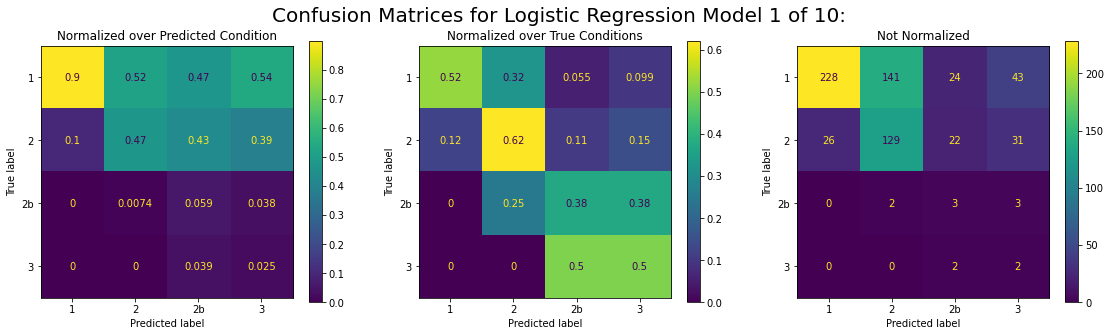

Logistic Regression Model 2 of 10:

              precision    recall  f1-score   support

           1   0.902041  0.506881  0.649046       436
           2   0.471223  0.629808  0.539095       208
          2b   0.070175  0.500000  0.123077         8
           3   0.026316  0.500000  0.050000         4

    accuracy                       0.545732       656
   macro avg   0.367439  0.534172  0.340304       656
weighted avg   0.749956  0.545732  0.604116       656



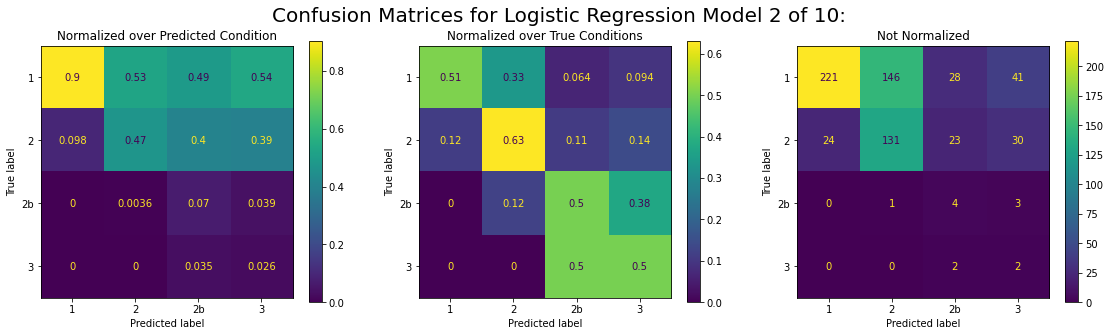

Logistic Regression Model 3 of 10:

              precision    recall  f1-score   support

           1   0.892308  0.532110  0.666667       436
           2   0.480769  0.600962  0.534188       208
          2b   0.061538  0.500000  0.109589         8
           3   0.014085  0.250000  0.026667         4

    accuracy                       0.551829       656
   macro avg   0.362175  0.470768  0.334278       656
weighted avg   0.746334  0.551829  0.613965       656



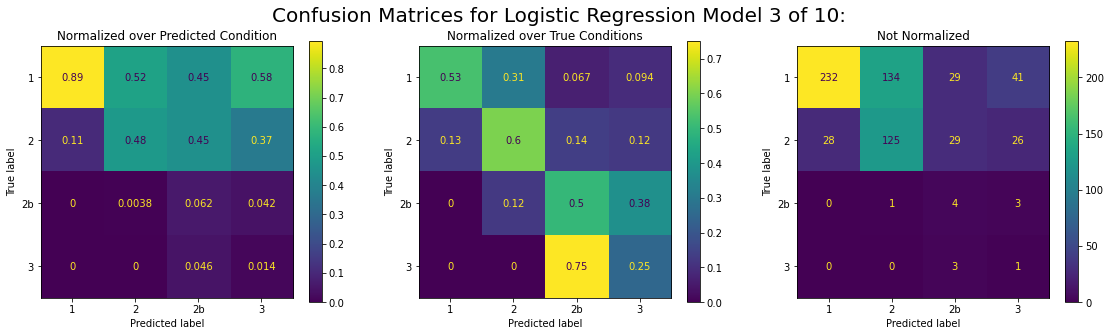

Logistic Regression Model 4 of 10:

              precision    recall  f1-score   support

           1   0.895753  0.532110  0.667626       436
           2   0.484733  0.610577  0.540426       208
          2b   0.063492  0.500000  0.112676         8
           3   0.027778  0.500000  0.052632         4

    accuracy                       0.556402       656
   macro avg   0.367939  0.535672  0.343340       656
weighted avg   0.749987  0.556402  0.616776       656



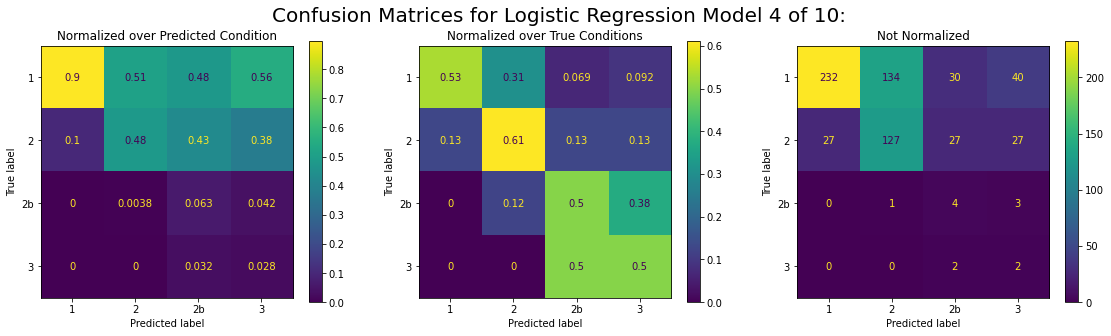

Logistic Regression Model 5 of 10:

              precision    recall  f1-score   support

           1   0.898438  0.527523  0.664740       436
           2   0.473485  0.600962  0.529661       208
          2b   0.063492  0.500000  0.112676         8
           3   0.027397  0.500000  0.051948         4

    accuracy                       0.550305       656
   macro avg   0.365703  0.532121  0.339756       656
weighted avg   0.748203  0.550305  0.611441       656



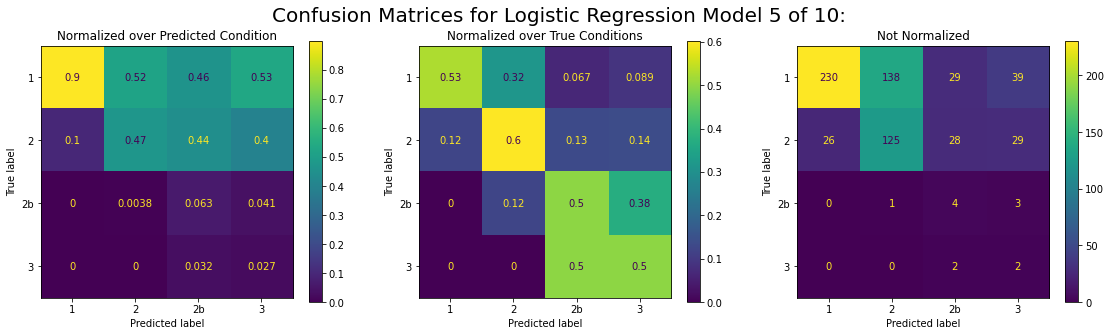

Logistic Regression Model 6 of 10:

              precision    recall  f1-score   support

           1   0.889734  0.536697  0.669528       436
           2   0.477099  0.600962  0.531915       208
          2b   0.061538  0.500000  0.109589         8
           3   0.030303  0.500000  0.057143         4

    accuracy                       0.556402       656
   macro avg   0.364669  0.534415  0.342044       656
weighted avg   0.743558  0.556402  0.615332       656



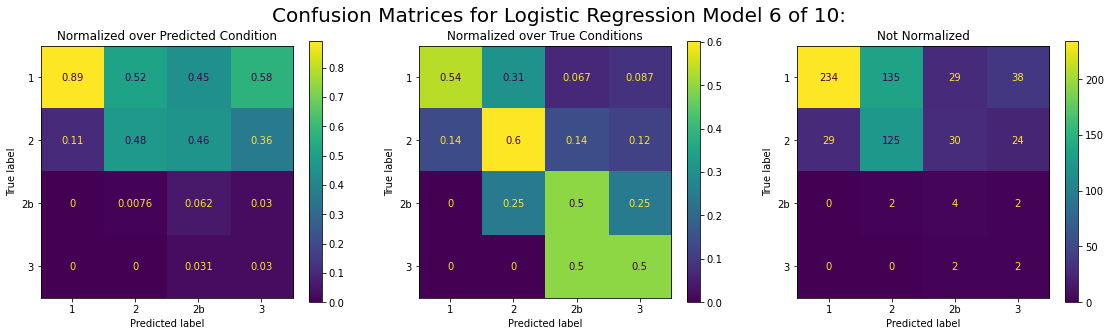

Logistic Regression Model 7 of 10:

              precision    recall  f1-score   support

           1   0.892720  0.534404  0.668580       436
           2   0.486056  0.586538  0.531590       208
          2b   0.055556  0.500000  0.100000         8
           3   0.027778  0.500000  0.052632         4

    accuracy                       0.550305       656
   macro avg   0.365527  0.530236  0.338200       656
weighted avg   0.748295  0.550305  0.614454       656



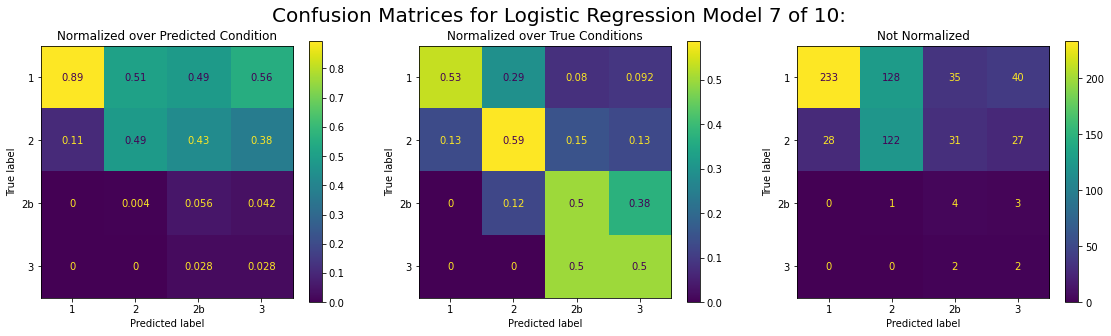

Logistic Regression Model 8 of 10:

              precision    recall  f1-score   support

           1   0.898833  0.529817  0.666667       436
           2   0.475472  0.605769  0.532770       208
          2b   0.074627  0.625000  0.133333         8
           3   0.029851  0.500000  0.056338         4

    accuracy                       0.554878       656
   macro avg   0.369695  0.565146  0.347277       656
weighted avg   0.749246  0.554878  0.613986       656



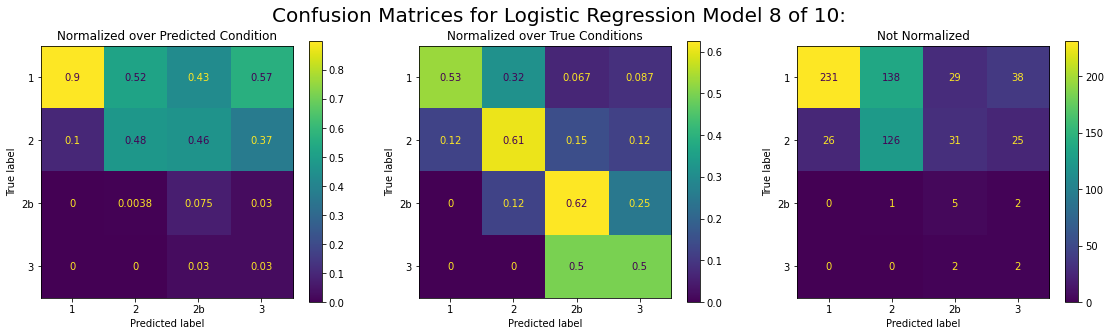

Logistic Regression Model 9 of 10:

              precision    recall  f1-score   support

           1   0.886598  0.591743  0.709766       436
           2   0.517094  0.581731  0.547511       208
          2b   0.064516  0.500000  0.114286         8
           3   0.028986  0.500000  0.054795         4

    accuracy                       0.586890       656
   macro avg   0.374298  0.543368  0.356589       656
weighted avg   0.754183  0.586890  0.647064       656



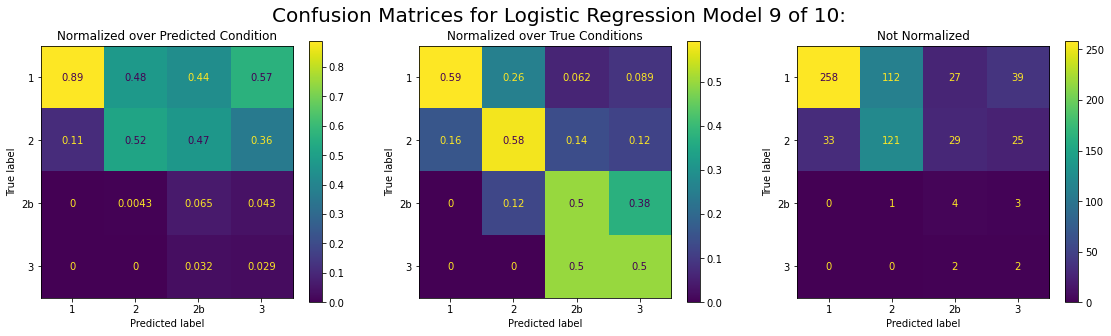

Logistic Regression Model 10 of 10:

              precision    recall  f1-score   support

           1   0.903614  0.516055  0.656934       436
           2   0.469091  0.620192  0.534161       208
          2b   0.054545  0.375000  0.095238         8
           3   0.025974  0.500000  0.049383         4

    accuracy                       0.547256       656
   macro avg   0.363306  0.502812  0.333929       656
weighted avg   0.750133  0.547256  0.607452       656



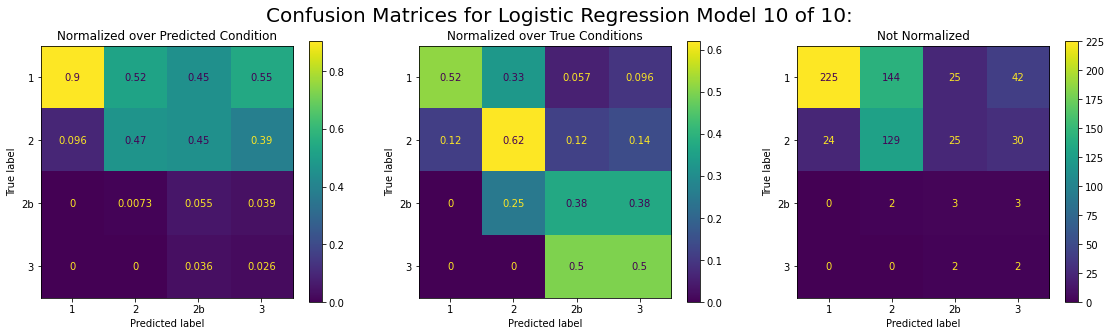

In [66]:
# For each logistic regression classifier in the cross-validation, print the macro recall, score report, and confusion matrices.
number_of_models = len(logistic_regression_scores['estimator'])
labels = ['1', '2', '2b', '3']
for index, logistic_regression_clf in zip(range(len(logistic_regression_scores['estimator'])), logistic_regression_scores['estimator']):
    y_test_predicted = logistic_regression_clf.predict(X_test)
    logistic_regression_recall_score = recall_score(y_test, y_test_predicted, average='macro', labels=labels)
    print('Logistic Regression Model %d of %d:' % (index + 1, number_of_models))
    print()
    print(classification_report(y_test, y_test_predicted, labels=labels, target_names=labels, digits=6))
        
    # Create a figure.
    fig = plt.figure(num=str(index + 1), figsize=(6.4 * 3, 4.8))
    fig.suptitle('Confusion Matrices for Logistic Regression Model %d of %d:' % (index + 1, number_of_models), fontsize=20)
    
    ax = plt.subplot(1, 3, 1)
    ax.set_title("Normalized over Predicted Condition", fontsize=12)
    plot_confusion_matrix(logistic_regression_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='pred', ax=ax)
    
    ax = plt.subplot(1, 3, 2)
    ax.set_title("Normalized over True Conditions", fontsize=12)
    plot_confusion_matrix(logistic_regression_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='true', ax=ax)
    
    ax = plt.subplot(1, 3, 3)
    ax.set_title("Not Normalized", fontsize=12)
    plot_confusion_matrix(logistic_regression_clf, X_test, y_test, labels=labels, display_labels=labels, normalize=None, ax=ax)

    plt.show()

In [67]:
print_elapsed_time(notebook_start_time)

Elapsed time is 309.70562535407953 seconds.


In [68]:
# Report statistics of the models built for each fold of the cross-validation.
for key in sorted(linear_svc_scores.keys()):
    if key != 'estimator':
        print('%s: mean = %f, std = %f' % (key, np.mean(linear_svc_scores[key]), np.std(linear_svc_scores[key])), sep='')
        print('%s :%s' % (key, linear_svc_scores[key]), sep='')
        print()

fit_time: mean = 0.211650, std = 0.072368
fit_time :[0.30418706 0.28607726 0.1587131  0.14087391 0.16362572 0.1570828
 0.17026734 0.13923573 0.25803185 0.33840108]

score_time: mean = 0.070293, std = 0.019043
score_time :[0.07664371 0.05707955 0.06100607 0.08007073 0.06230855 0.06315994
 0.09598231 0.04554367 0.10912633 0.05200815]

test_f1_macro: mean = 0.470951, std = 0.036214
test_f1_macro :[0.42765645 0.51554991 0.46436705 0.47001687 0.49088317 0.54852787
 0.44654921 0.42884191 0.45094574 0.4661703 ]

test_f1_weighted: mean = 0.470963, std = 0.036437
test_f1_weighted :[0.42759262 0.51543621 0.46537978 0.47059581 0.49128712 0.54887046
 0.44549743 0.42834733 0.45060653 0.46601305]

test_precision_macro: mean = 0.484963, std = 0.040389
test_precision_macro :[0.45173657 0.52180994 0.46746846 0.47082313 0.49659027 0.58513118
 0.44387379 0.48207112 0.44652567 0.48359546]

test_precision_weighted: mean = 0.484990, std = 0.040495
test_precision_weighted :[0.45191403 0.52189287 0.46818972 0

Support Vector Machine Model 1 of 10:

              precision    recall  f1-score   support

           1   0.900415  0.497706  0.641064       436
           2   0.472727  0.625000  0.538302       208
          2b   0.061224  0.375000  0.105263         8
           3   0.021978  0.500000  0.042105         4

    accuracy                       0.536585       656
   macro avg   0.364086  0.499427  0.331684       656
weighted avg   0.749216  0.536585  0.598294       656



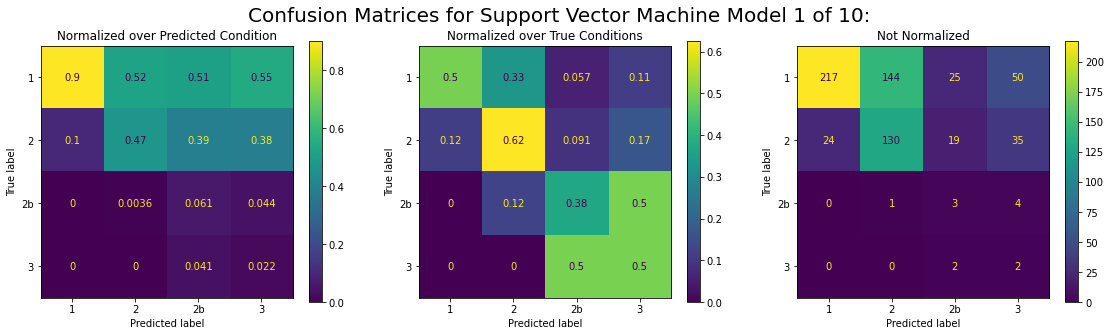

Support Vector Machine Model 2 of 10:

              precision    recall  f1-score   support

           1   0.888031  0.527523  0.661871       436
           2   0.479245  0.610577  0.536998       208
          2b   0.058824  0.375000  0.101695         8
           3   0.024691  0.500000  0.047059         4

    accuracy                       0.551829       656
   macro avg   0.362698  0.503275  0.336906       656
weighted avg   0.743039  0.551829  0.611696       656



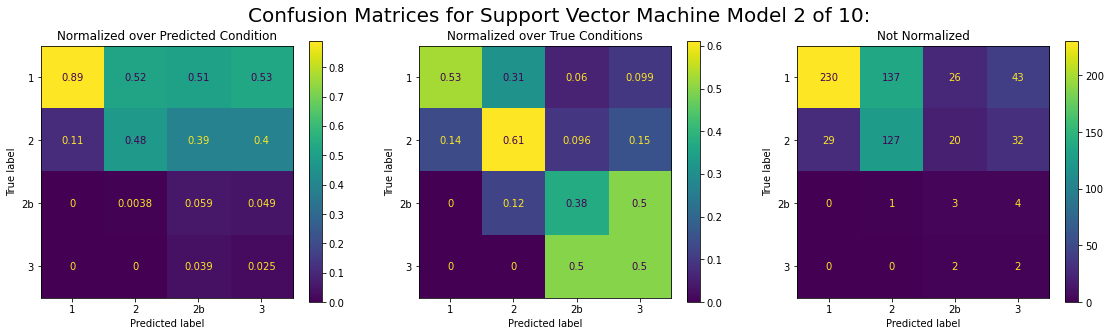

Support Vector Machine Model 3 of 10:

              precision    recall  f1-score   support

           1   0.885496  0.532110  0.664756       436
           2   0.475096  0.596154  0.528785       208
          2b   0.053571  0.375000  0.093750         8
           3   0.012987  0.250000  0.024691         4

    accuracy                       0.548780       656
   macro avg   0.356788  0.438316  0.327996       656
weighted avg   0.739904  0.548780  0.610777       656



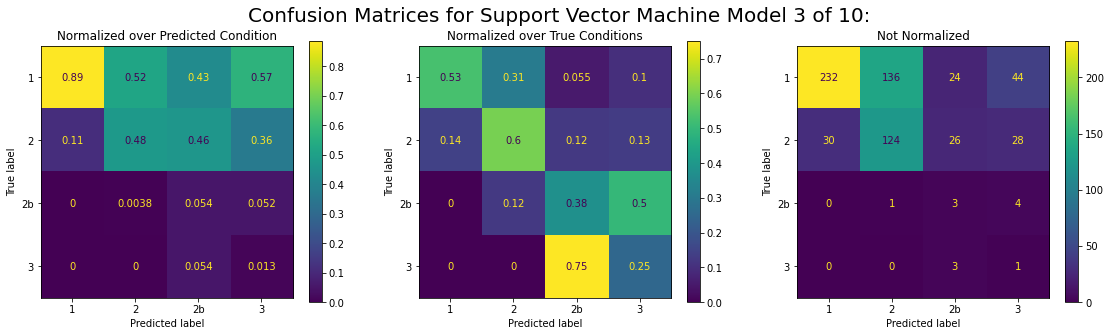

Support Vector Machine Model 4 of 10:

              precision    recall  f1-score   support

           1   0.872852  0.582569  0.698762       436
           2   0.506438  0.567308  0.535147       208
          2b   0.056604  0.375000  0.098361         8
           3   0.025316  0.500000  0.048193         4

    accuracy                       0.574695       656
   macro avg   0.365303  0.506219  0.345116       656
weighted avg   0.741550  0.574695  0.635595       656



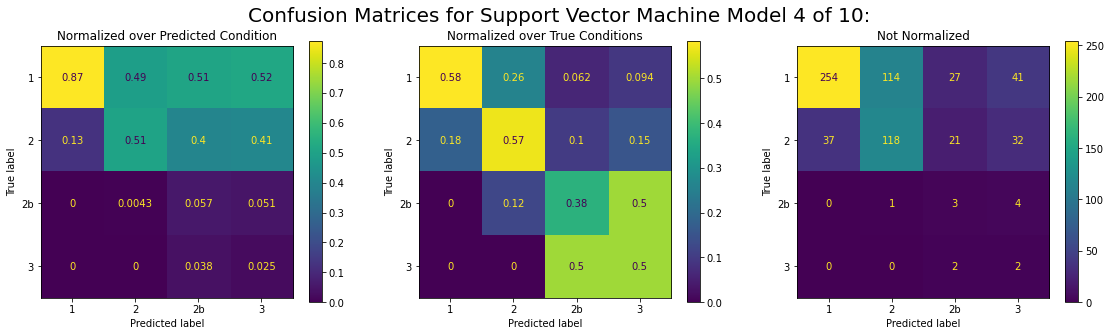

Support Vector Machine Model 5 of 10:

              precision    recall  f1-score   support

           1   0.894118  0.522936  0.659913       436
           2   0.475096  0.596154  0.528785       208
          2b   0.048387  0.375000  0.085714         8
           3   0.025641  0.500000  0.048780         4

    accuracy                       0.544207       656
   macro avg   0.360810  0.498522  0.330798       656
weighted avg   0.745648  0.544207  0.607607       656



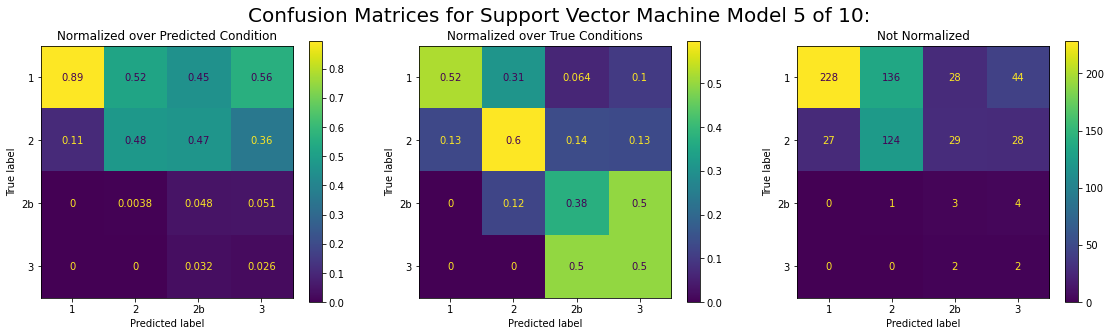

Support Vector Machine Model 6 of 10:

              precision    recall  f1-score   support

           1   0.886719  0.520642  0.656069       436
           2   0.473684  0.605769  0.531646       208
          2b   0.039216  0.250000  0.067797         8
           3   0.024096  0.500000  0.045977         4

    accuracy                       0.544207       656
   macro avg   0.355929  0.469103  0.325372       656
weighted avg   0.740161  0.544207  0.605724       656



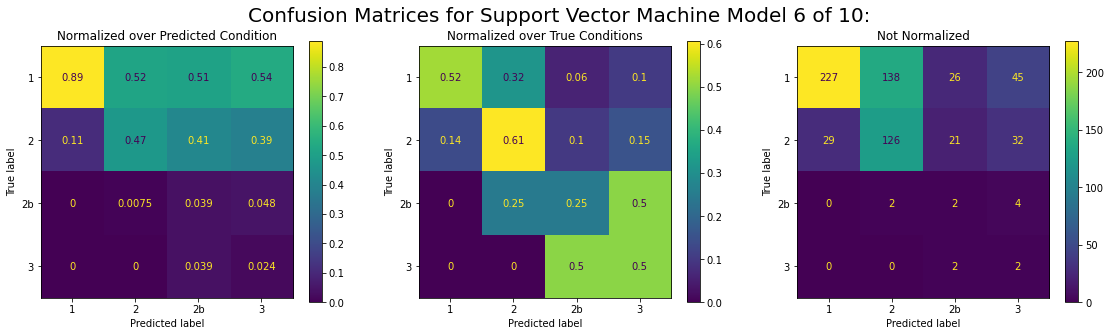

Support Vector Machine Model 7 of 10:

              precision    recall  f1-score   support

           1   0.887218  0.541284  0.672365       436
           2   0.489879  0.581731  0.531868       208
          2b   0.047619  0.375000  0.084507         8
           3   0.037500  0.750000  0.071429         4

    accuracy                       0.553354       656
   macro avg   0.365554  0.562004  0.340042       656
weighted avg   0.745812  0.553354  0.616984       656



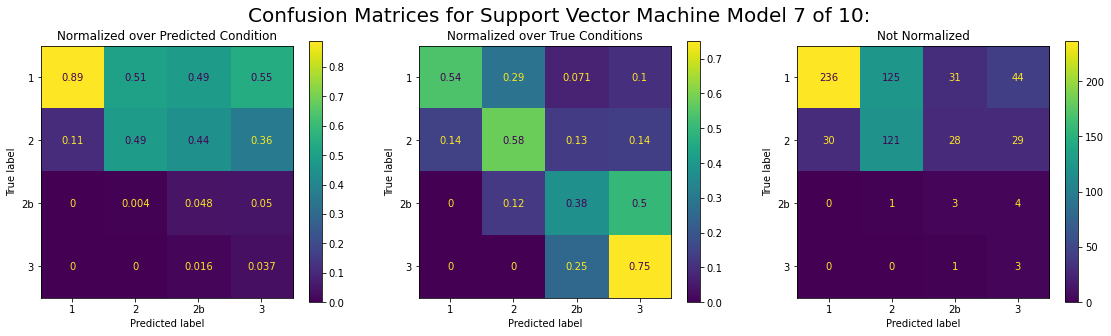

Support Vector Machine Model 8 of 10:

              precision    recall  f1-score   support

           1   0.890625  0.522936  0.658960       436
           2   0.474074  0.615385  0.535565       208
          2b   0.057692  0.375000  0.100000         8
           3   0.025641  0.500000  0.048780         4

    accuracy                       0.550305       656
   macro avg   0.362008  0.503330  0.335826       656
weighted avg   0.743116  0.550305  0.609297       656



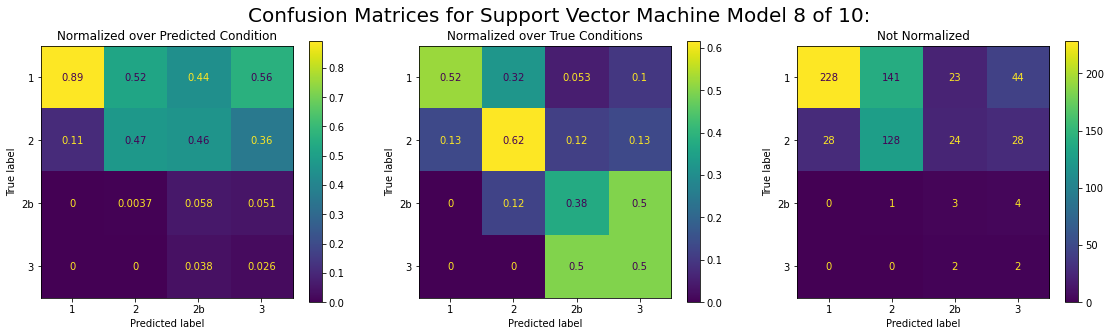

Support Vector Machine Model 9 of 10:

              precision    recall  f1-score   support

           1   0.870748  0.587156  0.701370       436
           2   0.513274  0.557692  0.534562       208
          2b   0.054545  0.375000  0.095238         8
           3   0.024691  0.500000  0.047059         4

    accuracy                       0.574695       656
   macro avg   0.365815  0.504962  0.344557       656
weighted avg   0.742290  0.574695  0.637098       656



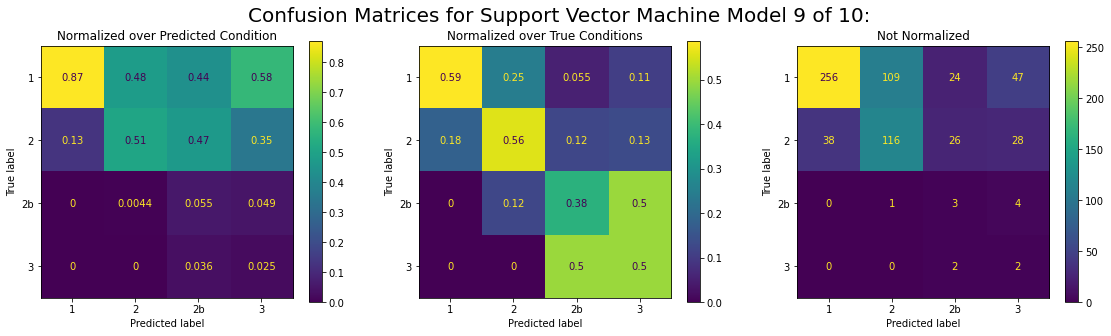

Support Vector Machine Model 10 of 10:

              precision    recall  f1-score   support

           1   0.903226  0.513761  0.654971       436
           2   0.476703  0.639423  0.546201       208
          2b   0.039216  0.250000  0.067797         8
           3   0.025641  0.500000  0.048780         4

    accuracy                       0.550305       656
   macro avg   0.361196  0.475796  0.329437       656
weighted avg   0.752099  0.550305  0.609626       656



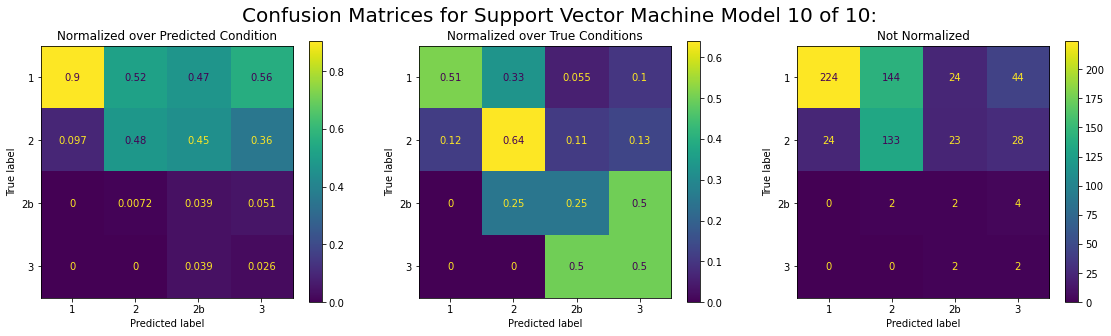

In [69]:
# For each support vector machine classifier in the cross-validation, print the macro recall, score report, and confusion matrices.
number_of_models = len(linear_svc_scores['estimator'])
labels = ['1', '2', '2b', '3']
for index, linear_svc_clf in zip(range(len(linear_svc_scores['estimator'])), linear_svc_scores['estimator']):
    y_test_predicted = linear_svc_clf.predict(X_test)
    linear_svc_recall_score = recall_score(y_test, y_test_predicted, average='macro', labels=labels)
    print('Support Vector Machine Model %d of %d:' % (index + 1, number_of_models))
    print()
    print(classification_report(y_test, y_test_predicted, labels=labels, target_names=labels, digits=6))
        
    # Create a figure.
    fig = plt.figure(num=str(index + 1), figsize=(6.4 * 3, 4.8))
    fig.suptitle('Confusion Matrices for Support Vector Machine Model %d of %d:' % (index + 1, number_of_models), fontsize=20)
    
    ax = plt.subplot(1,3,1)
    ax.set_title("Normalized over Predicted Condition", fontsize=12)
    plot_confusion_matrix(linear_svc_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='pred', ax=ax)
    
    ax = plt.subplot(1,3,2)
    ax.set_title("Normalized over True Conditions", fontsize=12)
    plot_confusion_matrix(linear_svc_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='true', ax=ax)
    
    ax = plt.subplot(1,3,3)
    ax.set_title("Not Normalized", fontsize=12)
    plot_confusion_matrix(linear_svc_clf, X_test, y_test, labels=labels, display_labels=labels, normalize=None, ax=ax)
    
    plt.show()

In [70]:
# Report statistics of the models built for each fold of the cross-validation.
for key in sorted(k_neighbors_scores.keys()):
    if key != 'estimator':
        print('%s: mean = %f, std = %f' % (key, np.mean(k_neighbors_scores[key]), np.std(k_neighbors_scores[key])), sep='')
        print('%s :%s' % (key, k_neighbors_scores[key]), sep='')
        print()

fit_time: mean = 0.029492, std = 0.018535
fit_time :[0.04666185 0.02231431 0.01889992 0.02045441 0.07996202 0.02453303
 0.02055693 0.02135158 0.02069449 0.01949263]

score_time: mean = 0.567115, std = 0.118160
score_time :[0.50592351 0.49004507 0.68677139 0.8407135  0.65633488 0.54991841
 0.44570565 0.46773458 0.54751945 0.4804883 ]

test_f1_macro: mean = 0.485300, std = 0.039935
test_f1_macro :[0.47720129 0.53690331 0.46118143 0.46493887 0.50313356 0.56816326
 0.44939501 0.4394057  0.50356651 0.44910948]

test_f1_weighted: mean = 0.485344, std = 0.040082
test_f1_weighted :[0.47754023 0.53705883 0.46188088 0.46555884 0.5033568  0.56836017
 0.44834346 0.43872423 0.50338594 0.44922617]

test_neg_log_loss: mean = -4.040818, std = 0.557369
test_neg_log_loss :[-4.38242671 -4.21553177 -3.63806652 -3.53017436 -4.12212377 -3.7939512
 -4.96303108 -4.09974132 -2.95768465 -4.70544477]

test_precision_macro: mean = 0.488281, std = 0.044508
test_precision_macro :[0.48175364 0.53727453 0.4642335  0.

k-Nearest Neighbor Model 1 of 10:

              precision    recall  f1-score   support

           1   0.829508  0.580275  0.682861       436
           2   0.403433  0.451923  0.426304       208
          2b   0.062500  0.500000  0.111111         8
           3   0.074074  1.000000  0.137931         4

    accuracy                       0.541159       656
   macro avg   0.342379  0.633050  0.339552       656
weighted avg   0.680451  0.541159  0.591218       656



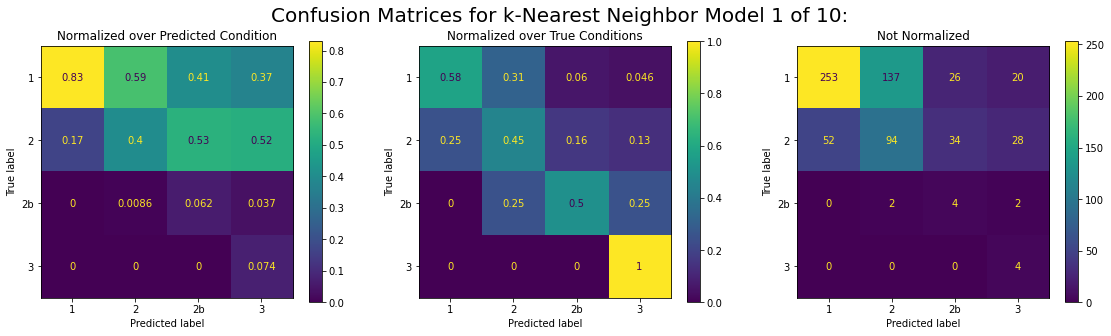

k-Nearest Neighbor Model 2 of 10:

              precision    recall  f1-score   support

           1   0.848485  0.577982  0.687585       436
           2   0.423581  0.466346  0.443936       208
          2b   0.040541  0.375000  0.073171         8
           3   0.071429  1.000000  0.133333         4

    accuracy                       0.542683       656
   macro avg   0.346009  0.604832  0.334506       656
weighted avg   0.699168  0.542683  0.599458       656



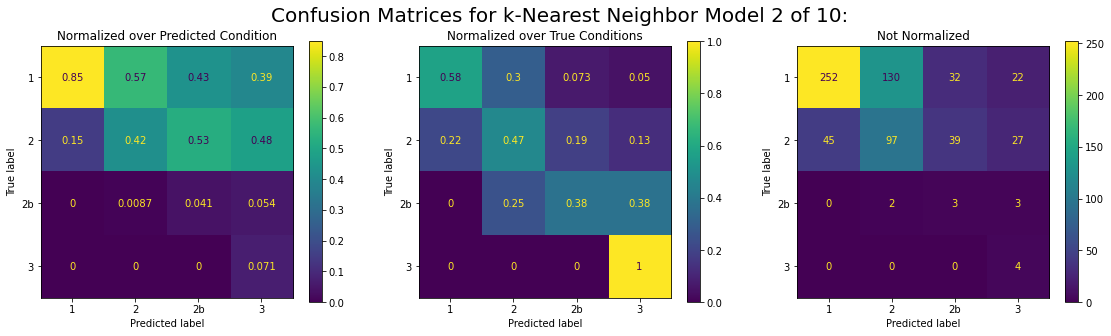

k-Nearest Neighbor Model 3 of 10:

              precision    recall  f1-score   support

           1   0.833876  0.587156  0.689098       436
           2   0.426724  0.475962  0.450000       208
          2b   0.066667  0.500000  0.117647         8
           3   0.052632  0.750000  0.098361         4

    accuracy                       0.551829       656
   macro avg   0.344975  0.578279  0.338776       656
weighted avg   0.690659  0.551829  0.602716       656



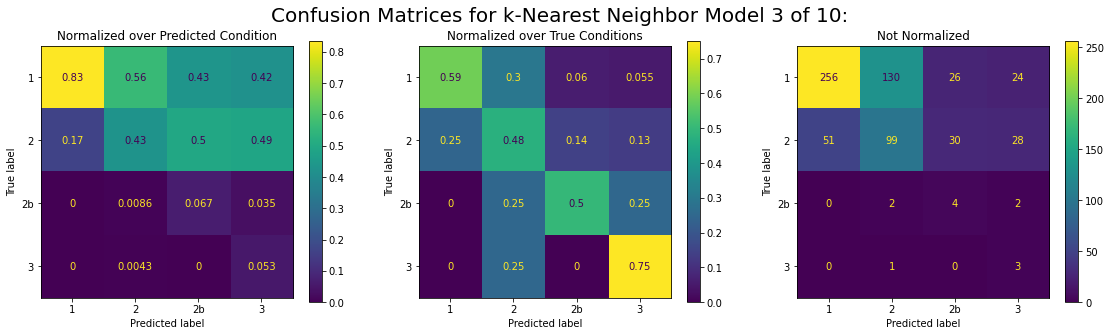

k-Nearest Neighbor Model 4 of 10:

              precision    recall  f1-score   support

           1   0.829582  0.591743  0.690763       436
           2   0.415525  0.437500  0.426230       208
          2b   0.054054  0.500000  0.097561         8
           3   0.057692  0.750000  0.107143         4

    accuracy                       0.542683       656
   macro avg   0.339213  0.569811  0.330424       656
weighted avg   0.684131  0.542683  0.596094       656



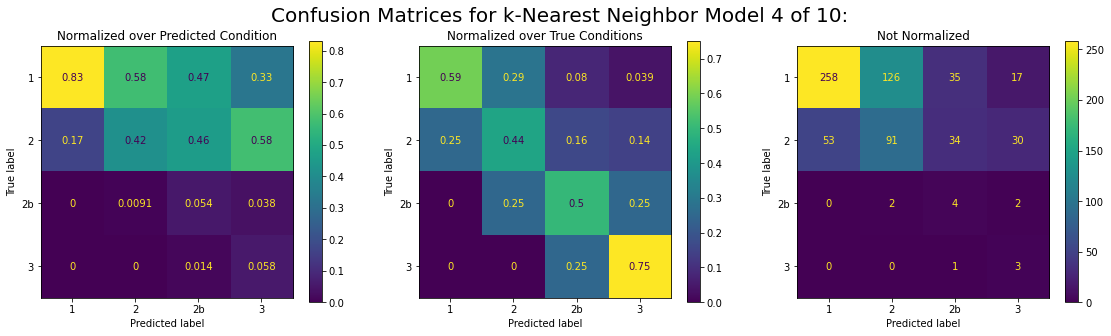

k-Nearest Neighbor Model 5 of 10:

              precision    recall  f1-score   support

           1   0.827243  0.571101  0.675712       436
           2   0.408511  0.461538  0.433409       208
          2b   0.064516  0.500000  0.114286         8
           3   0.068966  1.000000  0.129032         4

    accuracy                       0.538110       656
   macro avg   0.342309  0.633160  0.338110       656
weighted avg   0.680549  0.538110  0.588704       656



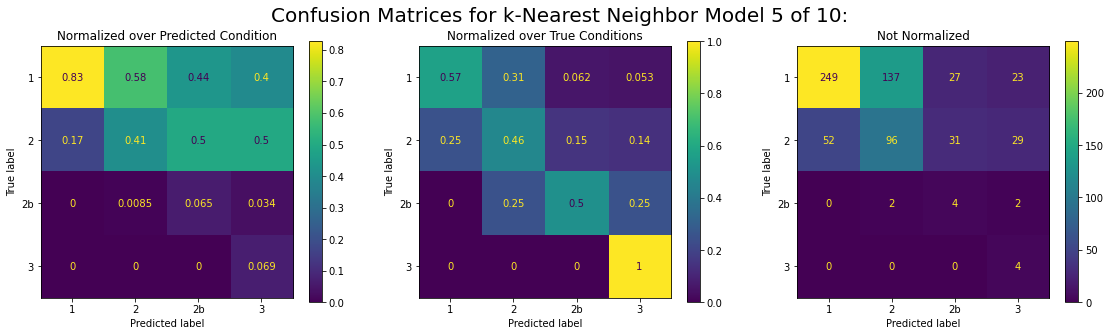

k-Nearest Neighbor Model 6 of 10:

              precision    recall  f1-score   support

           1   0.830065  0.582569  0.684636       436
           2   0.415179  0.447115  0.430556       208
          2b   0.058824  0.500000  0.105263         8
           3   0.068966  1.000000  0.129032         4

    accuracy                       0.541159       656
   macro avg   0.343258  0.632421  0.337372       656
weighted avg   0.684470  0.541159  0.593621       656



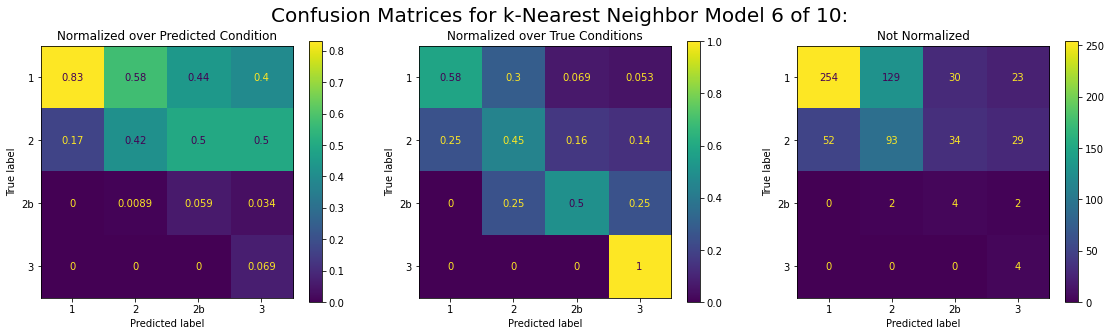

k-Nearest Neighbor Model 7 of 10:

              precision    recall  f1-score   support

           1   0.849673  0.596330  0.700809       436
           2   0.449541  0.471154  0.460094       208
          2b   0.053333  0.500000  0.096386         8
           3   0.070175  1.000000  0.131148         4

    accuracy                       0.557927       656
   macro avg   0.355681  0.641871  0.347109       656
weighted avg   0.708338  0.557927  0.613640       656



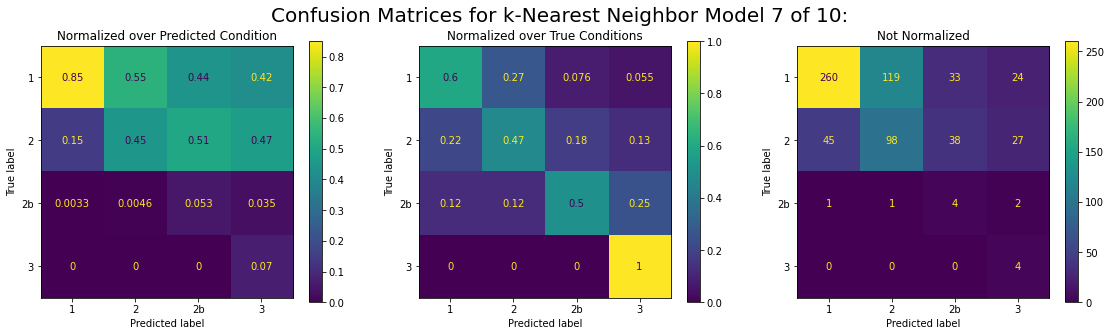

k-Nearest Neighbor Model 8 of 10:

              precision    recall  f1-score   support

           1   0.803681  0.600917  0.687664       436
           2   0.387560  0.389423  0.388489       208
          2b   0.064935  0.625000  0.117647         8
           3   0.090909  1.000000  0.166667         4

    accuracy                       0.536585       656
   macro avg   0.336771  0.653835  0.340117       656
weighted avg   0.658385  0.536585  0.582675       656



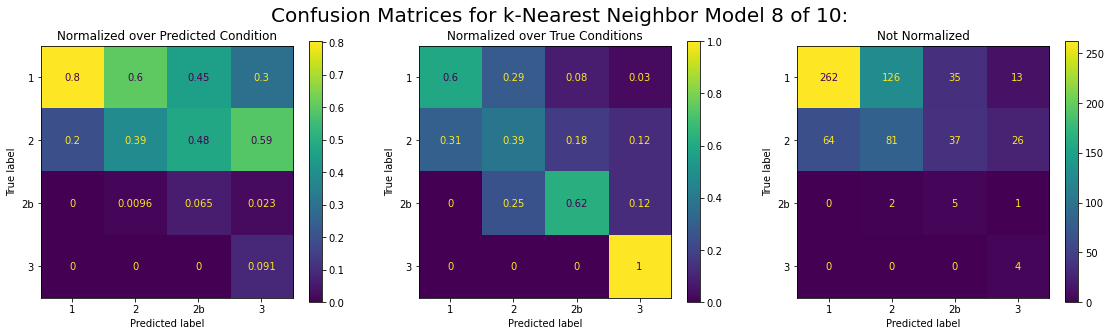

k-Nearest Neighbor Model 9 of 10:

              precision    recall  f1-score   support

           1   0.827922  0.584862  0.685484       436
           2   0.408889  0.442308  0.424942       208
          2b   0.056338  0.500000  0.101266         8
           3   0.076923  1.000000  0.142857         4

    accuracy                       0.541159       656
   macro avg   0.342518  0.631793  0.338637       656
weighted avg   0.681069  0.541159  0.592440       656



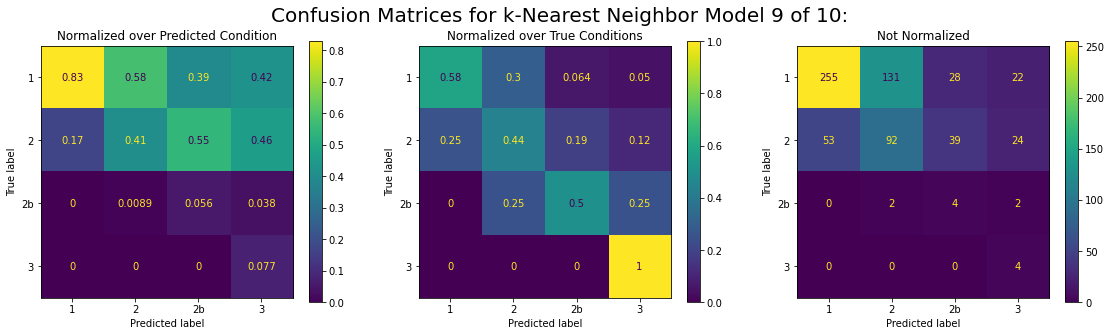

k-Nearest Neighbor Model 10 of 10:

              precision    recall  f1-score   support

           1   0.840909  0.594037  0.696237       436
           2   0.433628  0.471154  0.451613       208
          2b   0.062500  0.500000  0.111111         8
           3   0.068966  1.000000  0.129032         4

    accuracy                       0.556402       656
   macro avg   0.351501  0.641298  0.346998       656
weighted avg   0.697572  0.556402  0.608079       656



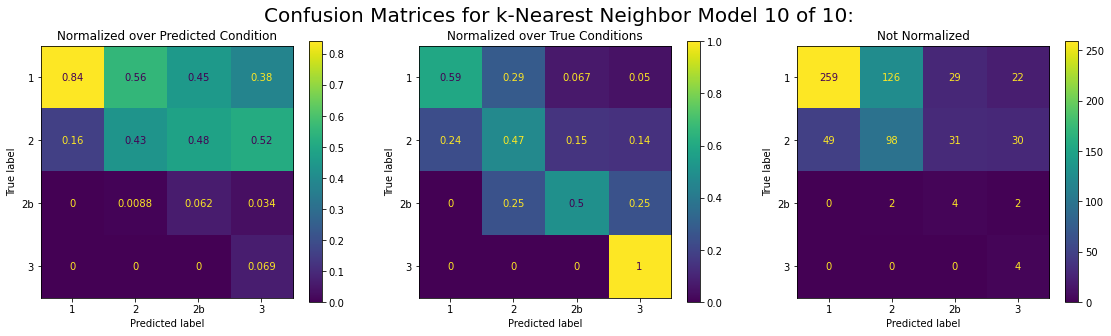

In [71]:
# For each k-Nearest Neighbor classifier in the cross-validation, print the macro recall, score report, and confusion matrices.
number_of_models = len(k_neighbors_scores['estimator'])
labels = ['1', '2', '2b', '3']
for index, knn_clf in zip(range(len(k_neighbors_scores['estimator'])), k_neighbors_scores['estimator']):
    y_test_predicted = knn_clf.predict(X_test)
    knn_recall_score = recall_score(y_test, y_test_predicted, average='macro', labels=labels)
    print('k-Nearest Neighbor Model %d of %d:' % (index + 1, number_of_models))
    print()
    print(classification_report(y_test, y_test_predicted, labels=labels, target_names=labels, digits=6))
        
    # Create a figure.
    fig = plt.figure(num=str(index + 1), figsize=(6.4 * 3, 4.8))
    fig.suptitle('Confusion Matrices for k-Nearest Neighbor Model %d of %d:' % (index + 1, number_of_models), fontsize=20)
    
    ax = plt.subplot(1, 3, 1)
    ax.set_title("Normalized over Predicted Condition", fontsize=12)
    plot_confusion_matrix(knn_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='pred', ax=ax)
    
    ax = plt.subplot(1, 3, 2)
    ax.set_title("Normalized over True Conditions", fontsize=12)
    plot_confusion_matrix(knn_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='true', ax=ax)
    
    ax = plt.subplot(1, 3, 3)
    ax.set_title("Not Normalized", fontsize=12)
    plot_confusion_matrix(knn_clf, X_test, y_test, labels=labels, display_labels=labels, normalize=None, ax=ax)

    plt.show()

In [72]:
print('Reports and graphics generated in %f seconds' % (elapsed_time(t0)))

Reports and graphics generated in 140.023343 seconds


In [73]:
print_elapsed_time(notebook_start_time)

Elapsed time is 407.0791444480419 seconds.
